# Medical Care Costs Analysis

Can a person's healthcare costs be predicted using patient demographics? This project will attempt to answer this, using a simulated dataset.

Here are the questions we are interested in answering for this data:
1. What is the breakdown in healthcare costs by: age, gender, smoking status, and BMI?
2. Using regression, can the cost of healthcare insurance be predicted using the demographics of the insured?

Data Source:https://github.com/stedy/Machine-Learning-with-R-datasets

First, let's clean the data. The steps we'll take include: investigating and filling in or dropping null values, checking for duplicates, and deleting any outliers or other data points that don't make sense.

In [1]:
#Import relevant libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Reading in the data and looking at the dataframe information:
insurance = pd.read_csv('insurance.csv')
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
#Taking a look at the top 5 columns:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Based on this initial look at the dataset, there are no null values to drop or fill in. Are there duplicates?

In [4]:
insurance.loc[insurance.duplicated(keep=False),:]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [5]:
#Removing one of the duplicate rows:
insurance.drop_duplicates(keep='first',inplace=True)

There were were two rows which looked to be duplicates. 

Next, we'll check for any other possibly erroneous data. In this dataset, this could be ages, or combinations of ages and children, that don't make sense.

In [6]:
#Checking the age column:
insurance.age.describe()

count    1337.000000
mean       39.222139
std        14.044333
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

The minimum age is 18 and the maximum is 64. These ages are reasonable. 

Now let's check for combinations of ages and children:

In [7]:
#Checking the children column:
insurance.children.describe()

count    1337.000000
mean        1.095737
std         1.205571
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64

In [8]:
#Checking out the rows where the number of children is high and the 
#age is low:
insurance.loc[(insurance.children >=4) & (insurance.age < 25),:].sort_values(by=['children','age'], ascending=False)

,age,sex,bmi,children,smoker,region,charges
166,20,female,37.000,5,no,southwest,4830.63000
984,20,male,30.115,5,no,northeast,4915.05985
32,19,female,28.600,5,no,southwest,4687.79700
754,24,male,33.630,4,no,northeast,17128.42608
494,21,male,25.700,4,yes,southwest,17942.10600
1095,18,female,31.350,4,no,northeast,4561.18850


There are some combinations of age and number of children that are questionable, although in the realm of possibility. Can we consider these to be outliers? Let's plot a boxplot of age versus number of children:

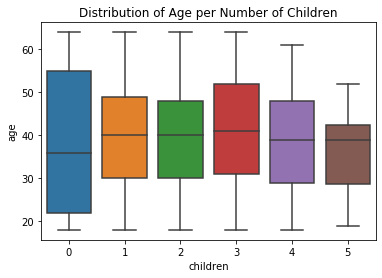

In [9]:
#plotting the boxplot
sns.boxplot(x='children',y='age',data=insurance)
plt.title('Distribution of Age per Number of Children')
plt.show()

According to the boxplot above, there are no true outliers in the data. However, as this data is still unlikely to be true given the combinations involved, we will remove anyone aged 20 and under with 4 or 5 children:

In [10]:
#removing data from the dataset:
insurance = insurance.loc[~((insurance.age<21) & (insurance.children >=4)),:]

Let's begin to answer some of the questions posed at the start of the project. What insights can we gain by splitting the cost information amongst different demographics? Specifically, age, gender, smoking status, and BMI?

The first demographic we'll examine is sex versus medical charges.

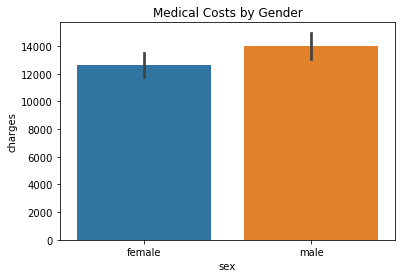

In [11]:
#Creating a graph of overall charges separated by gender:
sns.barplot(x='sex',y='charges',data=insurance)
plt.title('Medical Costs by Gender')
plt.show()

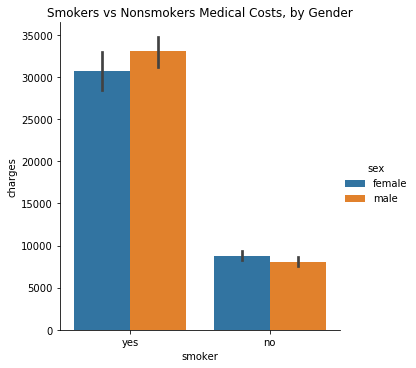

In [12]:
#Breaking this down by smoking status:
sns.catplot(x='smoker',y='charges',hue='sex',data=insurance,kind='bar')
plt.title('Smokers vs Nonsmokers Medical Costs, by Gender')
plt.show()

Based on the above graphs, males have overall more healthare costs than females. However, this is not necessarily the case if we break it further down into smokers versus nonsmokers. When we do that, women that don't smoke actually have higher healthcare costs than men who don't. But amongst smokers, men still run up a higher tab.

Next, let's examine the healthare costs by BMI. Using the official US National Institute of Health's definitions of body fat estimation (available on https://www.nhlbi.nih.gov/health/educational/lose_wt/risk.htm), each person will be categorized as either Underweight, Normal, Overweight, or Obese.

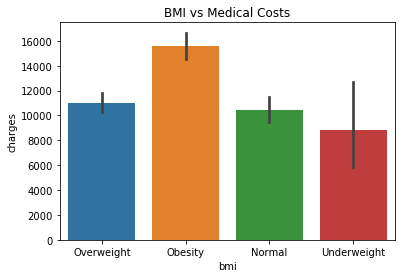

In [13]:
#Creating a classifying function:
def classify(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi >= 18.5 and bmi <25:
        return 'Normal'
    elif bmi >= 25 and bmi <30:
        return 'Overweight'
    else:
        return 'Obesity'

#Applying the classifying function to the BMI column:
bmi_class = insurance.bmi.apply(lambda x: classify(x))

#Graphing the BMI against cost of healthcare:
sns.barplot(x=bmi_class, y=insurance.charges)
plt.title('BMI vs Medical Costs')
plt.show()


Based on the graph of BMI versus healthcare costs, those in the Obesity category, or those who have a BMI greater or equal to 30, incur the highest healthcare costs. Those in the underweight category, meaning a BMI less than 18.5, incurred the least.

The last data I will graph is age verus healthcare costs:

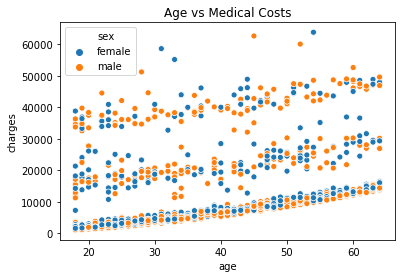

In [14]:
sns.scatterplot(x='age',y='charges',data=insurance, hue='sex')
plt.title('Age vs Medical Costs')
plt.show()

The scatterplot shows 3 distinct, parallel regions where it seems that insurance charges might have a positive linear correlation with age. 

In the next section, we will use two regression types to estimate medical costs from the given demographics, and compare to see which works the best. We will use linear regression and decision tree.

First we will prepare the dataframe for regression by making sure all feature columns are numerical or one hot encoded (a series of 1's and 0's). Then we'll examine the correlation between all the features and the charges column, before creating the regression models.

In [15]:
#Creating dummy variables for the feature columns:
sex_d = pd.get_dummies(insurance.sex)
smoker_d = pd.get_dummies(insurance.smoker, prefix='smoke')
region_d = pd.get_dummies(insurance.region)
bmi_d = pd.get_dummies(bmi_class)

#concatenating them to the dataframe:
insurance = pd.concat([sex_d, smoker_d, region_d, bmi_d, insurance], axis=1)

#Dropping the original columns sex, smoker, and region:
insurance.drop(columns=['sex','smoker','region','bmi'], inplace=True)

In [16]:
#Showing the correlation between features and the charges column:
insurance.corr().loc['charges',:]

female        -0.057075
male           0.057075
smoke_no      -0.787052
smoke_yes      0.787052
northeast      0.007244
northwest     -0.039939
southeast      0.072379
southwest     -0.042515
Normal        -0.107698
Obesity        0.201716
Overweight    -0.121030
Underweight   -0.045359
age            0.296421
children       0.074902
charges        1.000000
Name: charges, dtype: float64

There is a strong correlation between insurance charges and smoking, and to a lesser extent age and BMI. Interestingly, the sex, region and children columns do not seem to correlate much, if at all. In order to see if this makes a difference, first we'll run the regression models with all feature columns. Once we've decided on one regression model, we'll take out sex, region and children to see if that improves performance.

Now that the feature columns have been prepared, let's create the linear regression model:

In [17]:
#Importing the relevant libraries:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model_lr = LinearRegression() #instantiating Linear Regression model
X = insurance.iloc[:,:-2] #assigning the features to X
y = insurance.iloc[:,-1]  #assigning the charges column to y

#defining the training and testing set in the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=1)

#fitting the model to the training set
model_lr.fit(X_train,y_train)

#Determining the linear model's coefficients:
intercept = model_lr.intercept_
slope = model_lr.coef_
print('Intercept:',intercept)
print('Slope:',slope)

#Using the model to predict insurance charges given the test data set:
pred_lr = model_lr.predict(X_test)

Intercept: 8637.869744527343
Slope: [-4.66945883e+00  4.66945883e+00 -1.17999459e+04  1.17999459e+04
  3.79284616e+02  3.13771581e+02 -5.15995562e+02 -1.77060636e+02
 -8.49195597e+02  3.28649986e+03 -2.36604774e+02 -2.20069948e+03
  2.56419442e+02]


We now have the coefficients for our linear model of the form y = b0 + b1x1 + b2x2 +...etc, where b0 is the Intercept, and the Slope array are the x coefficients.

Let's implement the model again, but this time taking out the features we suspect do not correlate to costs.

In [18]:
#Dropping columns for the second model:
insurance2 = insurance.drop(['male','female','children','northeast','northwest','southeast','southwest'],
              axis=1)

model_lr2 = LinearRegression() #instantiating Linear Regression model
X2 = insurance2.iloc[:,:-2] #assigning the features to X
y2 = insurance2.iloc[:,-1]  #assigning the charges column to y

#defining the training and testing set in the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, train_size=0.7,random_state=1)

#fitting the model to the training set
model_lr2.fit(X_train2,y_train2)

#Determining the linear model's coefficients:
intercept2 = model_lr2.intercept_
slope2 = model_lr2.coef_
print('Intercept-less features:',intercept)
print('Slope-less features:',slope)

#Using the model to predict insurance charges given the test data set:
pred_lr2 = model_lr2.predict(X_test2)

Intercept-less features: 8637.869744527343
Slope-less features: [-4.66945883e+00  4.66945883e+00 -1.17999459e+04  1.17999459e+04
  3.79284616e+02  3.13771581e+02 -5.15995562e+02 -1.77060636e+02
 -8.49195597e+02  3.28649986e+03 -2.36604774e+02 -2.20069948e+03
  2.56419442e+02]


We've run the model twice, but which one gives a better result?  In order to determine this, we'll run two different metrics: mean_squared_error and R2 score.

Mean_squared_error is the average of the errors squared. That is, the difference between the actual values and the predicted values. It can be used to compare regression models, as a lower MSE usually means the model has performed better.

R2, also called the coefficient of determination, measures how close data is to the regression line. It is always a number between 0 and 1, with 1 indicating the model perfectly captures the data. A score of 0 would indicate the model did not fit the data at all.

In [19]:
#importing metrics libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#RMSE of the first model
rmse_lr = np.sqrt(mean_squared_error(pred_lr,y_test)) 
print('Root Mean Squared of first run: ',rmse_lr)

#RMSE of the second model
rmse_lr2 = np.sqrt(mean_squared_error(pred_lr2,y_test)) 
print('Root Mean Squared of second run: ',rmse_lr2)

#R2 score of the first model
print('R2 score first run:',r2_score(pred_lr,y_test))

#R2 score of the second model:
print('R2 score second run:',r2_score(pred_lr2,y_test))

Root Mean Squared of first run:  6094.079669156779
Root Mean Squared of second run:  7131.017680044769
R2 score first run: 0.6467576708878889
R2 score second run: 0.46730856590500236


Based on these metrics, the first linear regression model, where we used all available features, outperformed the second model. It had a lower root mean squared error and a higher R2, both indicating a better fit for the data. In fact, the R2 score was almost 20% higher, at 64.67%.

This concludes our analysis of healthcare costs from a simulated data set. We can see that these healthcare costs are heavily influenced by gender, smoking status, and BMI. The total cost of men's healthcare was higher than women's, and smokers' was much higher than nonsmokers. When we divided BMI into the National Insitute of Health categories, we determined that people in the obese category had higher costs than in the underweight category.